In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import stats

### Define KMeans Clones

In [ ]:
#add attribute to obs for easier accessing of sample timepoints
treatment=[]
for i in r310.obs["orig.ident"]:
    if "_pre_" in i:
        treatment.append("pre")
    elif "on" in i:
        if "later" not in i:
            treatment.append("on")
        else:
            treatment.append("on_later")
r310.obs["treatment"]=treatment

#load inferCNV data and match to anndata object
on=pd.read_csv("ribas_final/inferCNV_ribas_310_on_GEX_5pv2",index_col=0)
on=np.transpose(on)

on_later=pd.read_csv("ribas_final/inferCNV_ribas_310_on_later",index_col=0)
on_later=np.transpose(on_later)

pre=pd.read_csv("ribas_final/inferCNV_ribas_310_pre",index_col=0)
pre=np.transpose(pre)


#get barcodes for each timepoint
on_barcodes=[r310.obs_names[i] for i in range(len(r310.obs["treatment"])) if r310.obs["treatment"][i]=="on"]
pre_barcodes=[r310.obs_names[i] for i in range(len(r310.obs["treatment"])) if r310.obs["treatment"][i]=="pre"]
later_barcodes=[r310.obs_names[i] for i in range(len(r310.obs["treatment"])) if r310.obs["treatment"][i]=="on_later"]

#assemble matching data
infer_on_barcodes=on.index
tumor_on=pd.DataFrame()
modifier="-"+on_barcodes[0].split("-")[2]
for i in infer_on_barcodes:
    if i+modifier in on_barcodes:
        tumor_on[i+modifier]=on.loc[i]

infer_pre_barcodes=pre.index
tumor_pre=pd.DataFrame()
modifier="-"+pre_barcodes[0].split("-")[2]
for i in infer_pre_barcodes:
    if i+modifier in pre_barcodes:
        tumor_pre[i+modifier]=pre.loc[i]

infer_later_barcodes=on_later.index
tumor_later=pd.DataFrame()
modifier="-"+later_barcodes[0].split("-")[2]
for i in infer_later_barcodes:
    if i+modifier in later_barcodes:
        tumor_later[i+modifier]=on_later.loc[i]

infer_full=pd.concat([tumor_on,tumor_later,tumor_pre],axis=1)

shared_genes=np.intersect1d(tumor_on.index,tumor_pre.index)
shared_genes=np.intersect1d(shared_genes, tumor_later.index)

drop=[]
for i in infer_full.index:
    if i not in shared_genes:
        drop.append(i)
infer_full=infer_full.drop(drop)

infer_full=np.transpose(infer_full)

#final df of all timepoints inferCNV data
infer_full_np=np.asarray(infer_full)

#Perform KMeans clustering to define clones

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(infer_full)
r310.obs["inferCNV_clones"]=kmeans

## Analysis

In [2]:
r310=sc.read_h5ad("N_ribas310_clones.h5")

In [40]:
#z-scored version of data for some visualizations
zscr=sc.pp.scale(r310,copy=True)

In [3]:
#load in signatures from preprint
sigs=pd.read_csv("azizi_preprint_sigs_all.csv",index_col=[1])
sigs=sigs.drop('Unnamed: 0',axis=1)
redo=sigs.iloc[0:4]
sigs=sigs.drop(redo.index,axis=0)

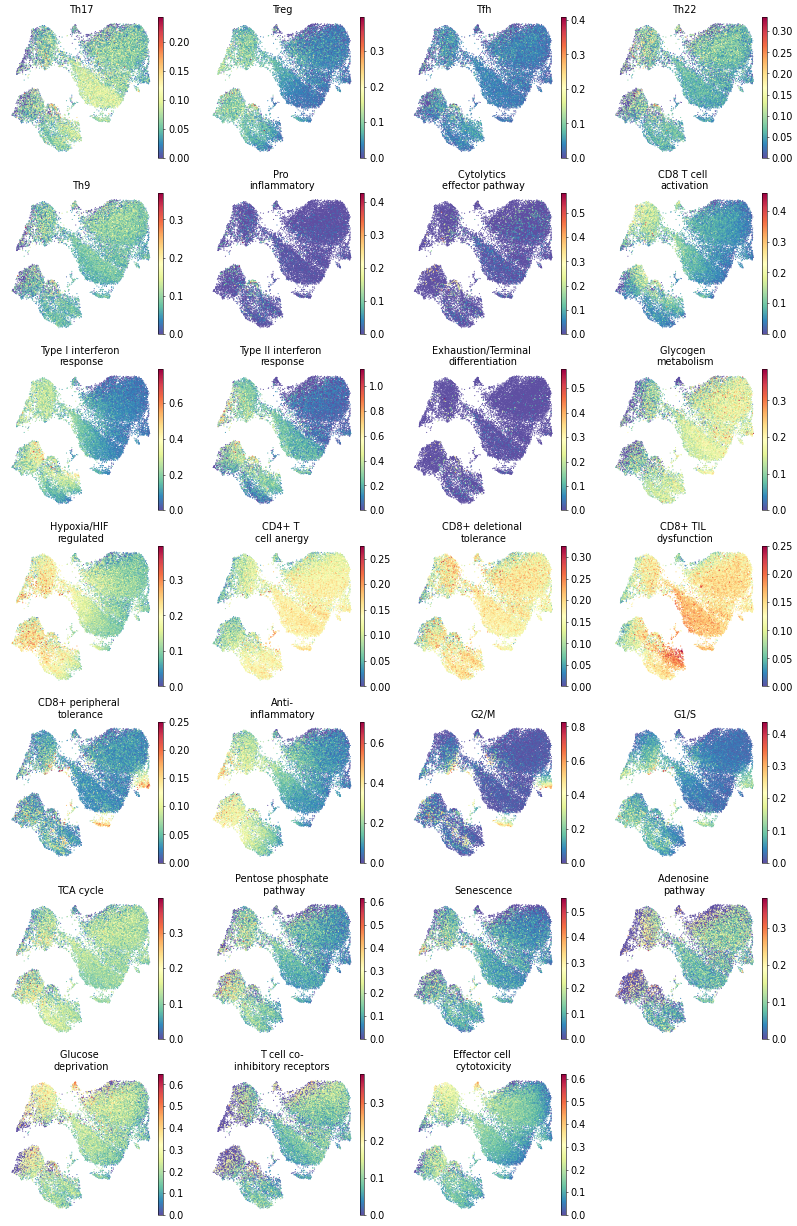

In [6]:
#plot signatures from preprint
adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(sigs)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=sigs.index)

signatures_types=sigs.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

#plot umaps of signatures
sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=sigs.index,
    palette='tab20', color_map='Spectral_r',
    s=10,
    save='r310_sigs1.pdf'
)

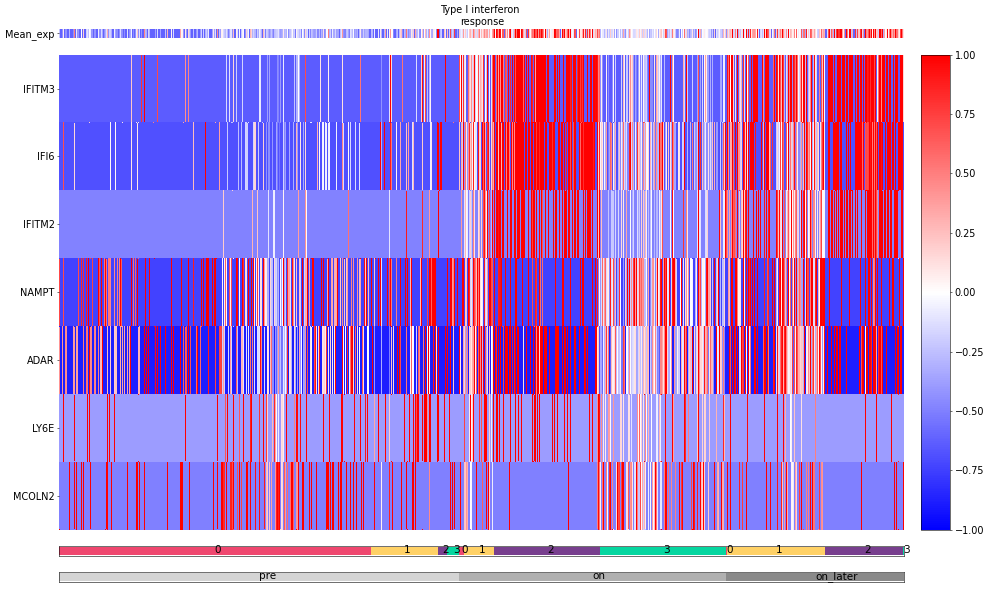

In [106]:
#example of visualizing using full_heatmap version 1
genes=full_heatmap(sigs, "Type I interferon \nresponse",r310,vmax=1)

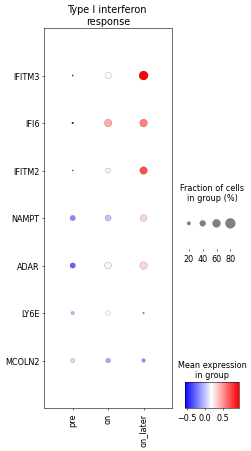

In [107]:
#example of dotplot visualization
sc.pl.dotplot(zscr,genes,groupby='treatment',
              figsize=(5,10),
              swap_axes=True,
              categories_order=["pre","on","on_later"],
             cmap='bwr',title="Type I interferon \nresponse")

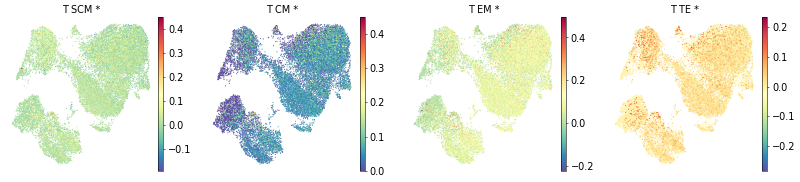

In [115]:
#Plot T cell signatures
#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(redo)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            name=sigs_np[i][j].split(" ")[0]
            sign=sigs_np[i][j].split(" ")[1]
            if name in adata_df.columns:
                if sign=="+":
                    temp.append(adata_df[name])
                elif sign=="-":
                    temp.append(-1*adata_df[name])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=redo.index)

signatures_types=redo.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=redo.index,
    palette='tab20', color_map='Spectral_r',
    s=10,
    save='.pdf'
)

In [116]:
ifn_sigs=pd.read_csv("CIN.csv", index_col=0, header=None)
ifn_sigs=ifn_sigs.drop(1,axis=1)

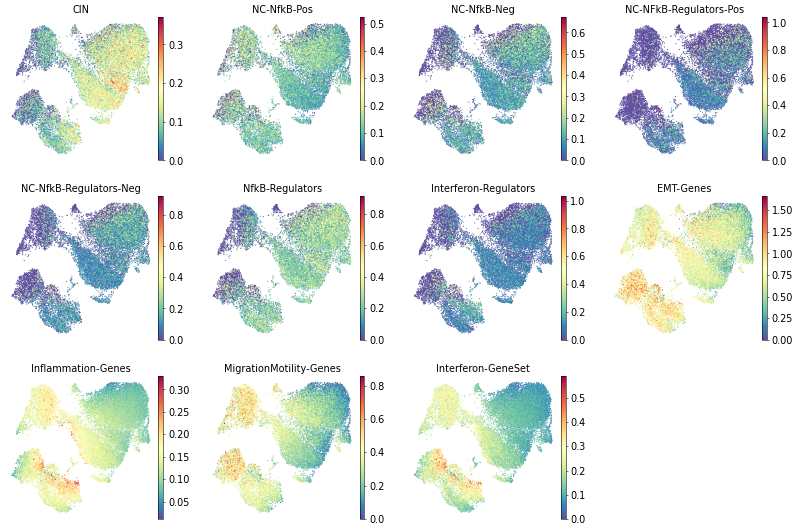

In [118]:
#plot CIN signatures

adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(ifn_sigs)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=ifn_sigs.index)

signatures_types=ifn_sigs.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=ifn_sigs.index,
    palette='tab20', color_map='Spectral_r', 
    s=10,
    save='r310supp2.pdf'
)

In [3]:
mitf_sigs=pd.read_csv("MITF_AXL_signatures.csv", index_col=None, header=0)
mitf_sigs=np.transpose(mitf_sigs)
mitf_sigs

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
AXL_sig,ANGPTL4,FSTL3,GPC1,TMSB10,SH3BGRL3,PLAUR,NGFR,SEC14L2,FOSL1,SERPINE1,...,P4HA2,PEA15,GLRX2,HAPLN3,RAB36,SOD2,ESYT2,IL18BP,FGFRL1,PLEC
MITF_sig,MITF,TYR,PMEL,PLP1,GPR143,MLANA,STX7,IRF4,ERBB3,CDH1,...,HACD3,SNCA,GNPTAB,DNAJA4,APOE,MTMR2,ATP6V1B2,VPS35L,EXOSC4,STAM


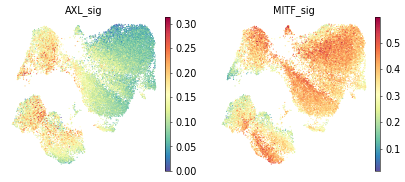

In [17]:
#plot AXL and MITF signatures

adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(mitf_sigs)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=mitf_sigs.index)

signatures_types=mitf_sigs.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=mitf_sigs.index,
    palette='tab20', color_map='Spectral_r', 
    s=10,
    #save='r310supp3.pdf'
)

In [11]:
exh_sigs=pd.read_csv("Tcell_exhaustion_signatures.csv", index_col=None, header=0)
exh_sigs=np.transpose(exh_sigs)

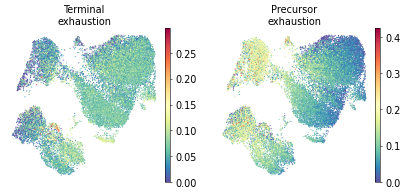

In [12]:
#plot exhaustion signatures

adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(exh_sigs)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=exh_sigs.index)

signatures_types=exh_sigs.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=exh_sigs.index,
    palette='tab20', color_map='Spectral_r', 
    s=10,
    save='r310supp3.pdf'
)

In [4]:
other_sigs=pd.read_csv("Grasso_Arnon_sigs.csv",header=None,nrows=9,index_col=0)
exh_sigs=other_sigs.iloc[[0,1,2,3,4,7,8]]

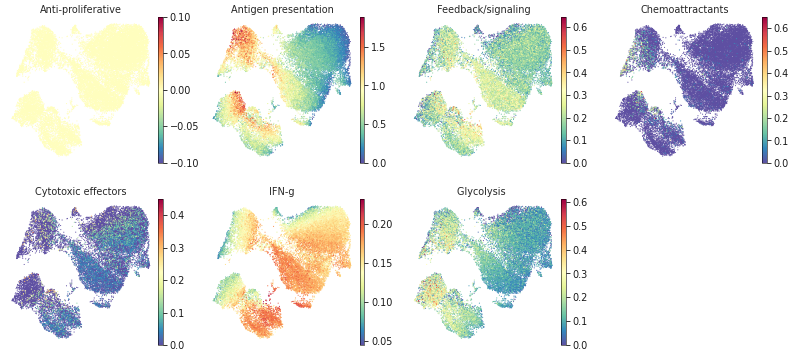

In [57]:
#plot signatures

adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(exh_sigs)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=exh_sigs.index)

signatures_types=exh_sigs.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=exh_sigs.index,
    palette='tab20', color_map='Spectral_r', 
    s=10,
    save='r310supp3.pdf'
)

In [30]:
imm_res=other_sigs.iloc[[5,6]]
imm_res=pd.concat((imm_res.iloc[[0]],mitf_sigs.iloc[[0]]))

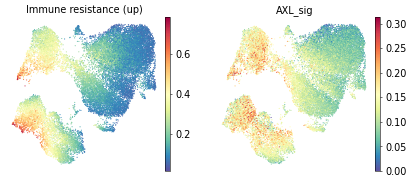

In [35]:
#plot immune resistance signature with AXL signatures

adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(imm_res)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if pd.isnull(sigs_np[i][j])==False:
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]]) #for induced genes
                #else:
                 #   temp.append(-1*adata_df[sigs_np[i][j]]) #for downregulated genes(take negative)
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=imm_res.index)

signatures_types=imm_res.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=imm_res.index,
    palette='tab20', color_map='Spectral_r', 
    s=10,
    save='2g.pdf'
)

### DEGs for Interesting inferCNV Clones

In [3]:
r310.obs["inferCNV_clones"]=pd.Categorical(r310.obs["inferCNV_clones"])

In [11]:
#run t-tests to analyze interesting clusters
ttest,scores=ttest_degs(r310,0,"inferCNV_clones")
ttest300=pd.concat((ttest[0:150],ttest[-150:]))
scores300=pd.concat((scores[0:150],scores[-150:]))

In [14]:
signature=ttest["Cluster 2"][0:300]

#make rnk files for GSEA
c2=pd.DataFrame({"genes":ttest300["Cluster 2"], "score": scores300["Cluster 2"]})
c2=c2.loc[0:300]
c2.to_csv("c2.rnk",header=None,index=None,sep='\t')

In [83]:
c1=pd.DataFrame({"genes":ttest["Cluster 1"], "score": scores["Cluster 1"]})
c1.to_csv("c1.rnk",header=None,index=None,sep='\t')

In [16]:
signature=pd.DataFrame({"Imm Res (Clone 2)":signature}).T

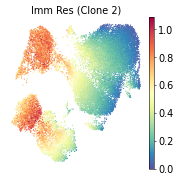

In [19]:
adata_df=r310.to_df()

#create cell signature markers by averaging expression for each cell across all gene markers
sigs_np=np.asarray(signature)
signatures=[]
for i in range(sigs_np.shape[0]):
    temp=[]
    for j in range(sigs_np.shape[1]):
        if sigs_np[i][j]!='NA':
            if sigs_np[i][j] in adata_df.columns:
                temp.append(adata_df[sigs_np[i][j]])
    if len(temp)==0:
        signatures.append([0 for k in range(adata_df.shape[0])])
    else:
        signatures.append(np.mean(temp,axis=0))    

signatures=np.asarray(signatures)

signatures=pd.DataFrame(np.transpose(signatures), columns=signature.index)

signatures_types=signature.index
signatures=np.asarray(signatures)
for i in range(signatures.shape[1]):
    r310.obs[signatures_types[i]]=signatures[:,i]

sc.set_figure_params(dpi=50, frameon = None)
sc.pl.umap(
    r310, 
    color=signature.index,
    palette='tab20', color_map='Spectral_r', 
    s=10,
    ncols=3
    #save='r310supp3.pdf'
)

### Clonal Expansion Visualizations

In [124]:
palette=["#EF476F","#FFD166","#783F8E","#06D6A0"]

In [16]:
#randomize points for plotting
randomize=np.arange(len(r310.obs["treatment"]))
np.random.shuffle(randomize)

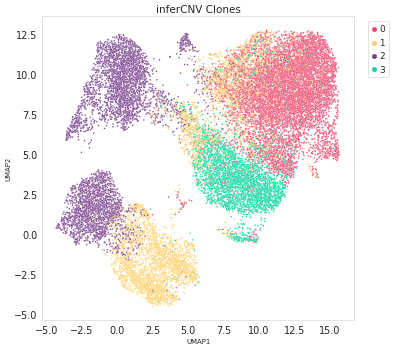

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("whitegrid", {'axes.grid' : False})
scatter=sns.scatterplot(x=r310.obsm["X_umap"][:,0][randomize],y=r310.obsm["X_umap"][:,1][randomize], hue=r310.obs["inferCNV_clones"][randomize],s=5,palette=palette)
scatter.legend(bbox_to_anchor= (1.03, 1) );
scatter.set_xlabel("UMAP1", fontsize = 10)
scatter.set_ylabel("UMAP2", fontsize = 10)
scatter.set_title("inferCNV Clones", fontsize = 15)
plt.savefig("figures/2d_1.pdf",format='pdf')

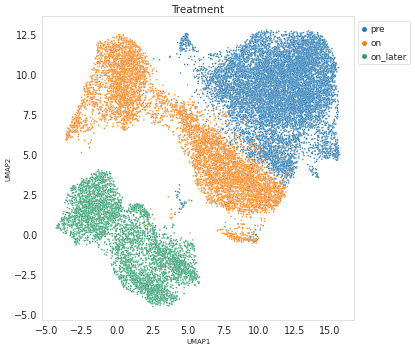

In [42]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("whitegrid", {'axes.grid' : False})
scatter=sns.scatterplot(x=r310.obsm["X_umap"][:,0][randomize],y=r310.obsm["X_umap"][:,1][randomize], ax=ax,hue=r310.obs["treatment"][randomize],s=5,hue_order=["pre","on","on_later"])
scatter.legend(bbox_to_anchor= (1, 1) );
scatter.set_xlabel("UMAP1", fontsize = 10)
scatter.set_ylabel("UMAP2", fontsize = 10)
scatter.set_title("Treatment", fontsize = 15)
plt.savefig("figures/2c.pdf",format='pdf')

In [25]:
label=[str(i) for i in range(4)]
treatment=r310.obs['treatment']
clonality=r310.obs['inferCNV_clones']

In [26]:
#create dict of pre source nodes
pre_clones={}
for i in range(len(treatment)):
    if treatment[i]=='pre':
        if clonality[i]!=-1:
            if clonality[i] in pre_clones:
                #pre_clones[clonality[i]]=pre_clones[clonality[i]]+[r310.obs_names[i]]
                pre_clones[clonality[i]]=pre_clones[clonality[i]]+1
            else:
                #pre_clones[clonality[i]]=[r310.obs_names[i]]
                pre_clones[clonality[i]]=1


In [27]:
#create dict of on source nodes
on_clones={}
for i in range(len(treatment)):
    if treatment[i]=='on':
        if clonality[i]!=-1:
            if clonality[i] in on_clones:
                on_clones[clonality[i]]=on_clones[clonality[i]]+1
            else:
                on_clones[clonality[i]]=1


In [28]:
#create dict of on later nodes
later_clones={}
for i in range(len(treatment)):
    if treatment[i]=='on_later':
        if clonality[i]!=-1:
            if clonality[i] in later_clones:
                later_clones[clonality[i]]=later_clones[clonality[i]]+1
            else:
                later_clones[clonality[i]]=1

In [29]:
clone_by_time={}
for i in range(4):
    if i in pre_clones:
        clone_by_time[str(i)]=[pre_clones[i]/np.sum(list(pre_clones.values()))]
    else:
        clone_by_time[str(i)]=[0]
        
    if i in on_clones:
        clone_by_time[str(i)]=clone_by_time[str(i)]+[on_clones[i]/np.sum(list(on_clones.values()))]
    else:
        clone_by_time[str(i)]=clone_by_time[str(i)]+[0]
        
    if i in later_clones:
        clone_by_time[str(i)]=clone_by_time[str(i)]+[later_clones[i]/np.sum(list(later_clones.values()))]
    else:
        clone_by_time[str(i)]=clone_by_time[str(i)]+[0]

In [30]:
clone_by_time

{'0': [0.7781453634085213, 0.01969628627274094, 0.006296379581740499],
 '1': [0.16852130325814535, 0.1088558111562171, 0.5516078255003373],
 '2': [0.02175438596491228, 0.39933844534656443, 0.43512480323813807],
 '3': [0.031578947368421054, 0.4721094572244775, 0.006970991679784124]}

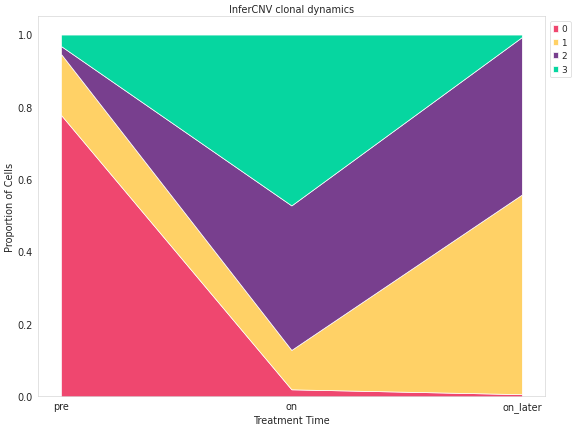

In [41]:
times = ["pre","on","on_later"]


fig, ax = plt.subplots(figsize=(13,10))
ax.stackplot(times, clone_by_time.values(),
             labels=clone_by_time.keys(),
             colors=palette)
ax.legend(loc='upper right', bbox_to_anchor=(1.06, 1))
ax.set_title('InferCNV clonal dynamics')
ax.set_xlabel('Treatment Time')
ax.set_ylabel('Proportion of Cells')

plt.savefig("figures/2d_2.pdf",format='pdf')

plt.show()

### CD58 Violin Plot Analysis

In [1]:
#Analyze CD58 expression per clone
r310_df=r310.to_df()
fig, axs = plt.subplots(1, 4, figsize=(12,5),sharey=True)
for i in range(4):
    clone=subsample(r310,"inferCNV_clones",[i])
    df=pd.DataFrame({"Clone "+str(i):clone.to_df()["CD58"]})
    sns.violinplot(data=df,ax=axs[i],color=palette[i])
plt.suptitle("CD58 Expression")
#plt.savefig("figures/2g_all_clones.pdf",format='pdf')

In [ ]:
r310_df=r310.to_df()
fig, axs = plt.subplots(1, 4, figsize=(12,5),sharey=True)
for i in range(4):
    clone=subsample(r310,"inferCNV_clones",[i])
    df=pd.DataFrame({"Clone "+str(i):clone.to_df()["CD58"]})
    sns.violinplot(data=df,ax=axs[i],color=palette[i])
plt.suptitle("CD58 Expression")

In [ ]:
#make corresponding boxplot
r310_df=r310.to_df()
fig, axs = plt.subplots(1, 4, figsize=(12,5),sharey=True)
for i in range(4):
    clone=subsample(r310,"inferCNV_clones",[i])
    df=pd.DataFrame({"Clone "+str(i):clone.to_df()["CD58"]})
    sns.boxplot(data=df,ax=axs[i],color=palette[i])
plt.suptitle("CD58 Expression")
plt.savefig("2g_all_clones_BOXPLOT.pdf",format='pdf')

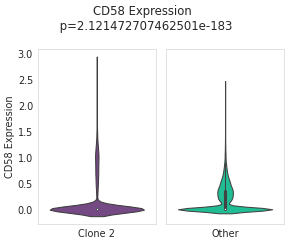

In [58]:
r310_df=r310.to_df()
fig, axs = plt.subplots(1, 2, figsize=(6,5),sharey=True)

clone=subsample(r310,"inferCNV_clones",[2])
df_2=pd.DataFrame({"Clone "+str(2):clone.to_df()["CD58"]})
sns.violinplot(data=df_2,ax=axs[0],color=palette[2])
axs[0].set_ylabel("CD58 Expression")
clone=subsample(r310,"inferCNV_clones",[0,1,3])
df_other=pd.DataFrame({"Other":clone.to_df()["CD58"]})
sns.violinplot(data=df_other,ax=axs[1],color=palette[3])

plt.suptitle("CD58 Expression \n p="+str(p))
plt.tight_layout()

plt.savefig("figures/2g.pdf",format='pdf')

In [51]:
import scipy
stat,p=scipy.stats.mannwhitneyu(df_2["Clone 2"],df_other["Other"])

Text(0.5, 0.98, 'Expression of Antigen Presentation Markers')

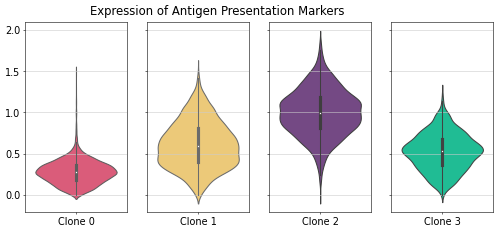

In [103]:
r310.obs["Antigen presentation"]

r310_df=r310.to_df()
fig, axs = plt.subplots(1, 4, figsize=(12,5),sharey=True)
for i in range(4):
    clone=subsample(r310,"inferCNV_clones",[i])
    df=pd.DataFrame({"Clone "+str(i):clone.obs["Antigen presentation"]})
    sns.violinplot(data=df,ax=axs[i],color=palette[i])
plt.suptitle("Expression of Antigen Presentation Markers")

### TCR Gini Analysis

Compute Gini scores

In [4]:
pre_tcr=pd.read_csv("ribas_tcr/ribas1_pre_tcr_S35_L004_TR_frequency.csv")
on_tcr=pd.read_csv("ribas_tcr/ribas1_on_tcr_S36_L004_TR_frequency.csv")
later_tcr=pd.read_csv("ribas_tcr/ribas_310_on_later_previd_3_TCR_TR_frequency.csv")

In [6]:
gini_simul=[]
for i in range(len(pre_tcr['occurrences'])):
    gini_simul+=[float(i) for j in range(pre_tcr['occurrences'][i])]
gini_simul=np.asarray(gini_simul)

In [7]:
gini(gini_simul)

0.7025628830197882

In [35]:
gini_simul=[]
for i in range(len(on_tcr['occurrences'])):
    gini_simul+=[float(i) for j in range(on_tcr['occurrences'][i])]
gini_simul=np.asarray(gini_simul)

In [36]:
gini(gini_simul)

0.6957874739442089

In [37]:
gini_simul=[]
for i in range(len(later_tcr['occurrences'])):
    gini_simul+=[float(i) for j in range(later_tcr['occurrences'][i])]
gini_simul=np.asarray(gini_simul)

In [38]:
gini(gini_simul)

0.7639207046849186

### FUNCTIONS

In [31]:
def subsample(adata, select, key):
    #select is the column in adata.obs that we will subsample by
    #key is the entries in obs that we will select
    index=[]
    for i in range(len(adata.obs[select])):
        if adata.obs[select][i] in key:
            index.append(i)
    return adata[index,:]

In [3]:
#code from https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [5]:
def ttest_degs(adata,n_genes_per_cluster,annot):
    #compute DEGs using a T-test
    
    #pca of n_components
    sc.pp.pca(adata, n_comps= 50)

    #communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']), k = 30)

    #adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
    #adata.uns['PhenoGraph_Q'] = Q

    sc.tl.rank_genes_groups(adata, annot , method='t-test', key_added = "t-test")

    ttest=pd.DataFrame()
    ttest_scores=pd.DataFrame()
    for i in np.unique(adata.obs[annot]):
        genelist=[]
        scores=[]
        counts=0
        tmp=sc.get.rank_genes_groups_df(adata,key='t-test',group=str(i))
        ttest_ii=tmp["names"]
        score_ii=tmp["scores"]
        j=0
        for j in range(len(ttest_ii)):
            if ("MT-" not in ttest_ii[j]) and ("RPS" not in ttest_ii[j]) and ("RPL" not in ttest_ii[j]):
                genelist.append(ttest_ii[j])
                scores.append(score_ii[j])

        ttest["Cluster "+str(i)]=genelist
        ttest_scores["Cluster "+str(i)]=scores
    return ttest,ttest_scores

In [6]:
def get_coords(arr):
    #arr=np.asarray(arr).flatten()
    coords=[0]
    labels=[arr[0]]
    tmp=0
    for i in range(len(arr)):
        if arr[i]!=arr[tmp]:
            coords.append(i)
            labels.append(arr[i])
            tmp=i
    coords.append(len(arr))
    return coords,labels

In [8]:
def make_heatmap(df, sig, adata):
    #assemble data to make heatmaps
    genes=df.loc[sig]
    heatmap=pd.DataFrame()
    adata_df=adata.to_df()
    for i in genes:
        if not pd.isnull(i):
            if i in adata_df.columns:
                heatmap[i]=adata_df[i]
            else:
                heatmap[i]=[0 for i in range(adata_df.shape[0])]
    return heatmap

def full_heatmap(df, sig, adata, vmax=3, thresh=200,mean_thresh=.1,exclude=None):
    #this version of the function includes a heatmap showing mean signature expression
    
    palette={0:"#EF476F",1:"#FFD166",2:"#783F8E",3:"#06D6A0"}
    
    pre=subsample(adata,"treatment",['pre'])
    pre_heatmap=make_heatmap(df, sig, pre)
    pre_clone_df=pd.DataFrame({"clone":pre.obs["inferCNV_clones"],"id":pre.obs_names})
    pre_heatmap=pd.concat((pre_clone_df,pre_heatmap),axis=1).sort_values(by="clone")
    pre_clones=list(pre_heatmap["clone"])
    pre_heatmap=pre_heatmap.drop(["id","clone"],axis=1)

    on=subsample(adata,"treatment",['on'])
    on_heatmap=make_heatmap(df, sig, on)
    on_clone_df=pd.DataFrame({"clone":on.obs["inferCNV_clones"],"id":on.obs_names})
    on_heatmap=pd.concat((on_clone_df,on_heatmap),axis=1).sort_values(by="clone")
    on_clones=list(on_heatmap["clone"])
    on_heatmap=on_heatmap.drop(["id","clone"],axis=1)
    
    
    later=subsample(adata,"treatment",['on_later'])
    later_heatmap=make_heatmap(df, sig, later)
    later_clone_df=pd.DataFrame({"clone":later.obs["inferCNV_clones"],"id":later.obs_names})
    later_heatmap=pd.concat((later_clone_df,later_heatmap),axis=1).sort_values(by="clone")
    later_clones=list(later_heatmap["clone"])
    later_heatmap=later_heatmap.drop(["id","clone"],axis=1)
    
    heatmap=pd.concat((pre_heatmap, on_heatmap, later_heatmap),axis=0)
    heatmap=np.transpose(heatmap)
    
    #clones=np.asarray([pre_clones]+[on_clones]+[later_clones]).flatten()
    clones=pre_clones+on_clones+later_clones
    drop=[]

    for i in heatmap.index:
        #nonzero=0
        mean=np.mean(heatmap.loc[i])
        if mean<mean_thresh:
            drop.append(i)
        heatmap.loc[i]=stats.zscore(heatmap.loc[i])    
    heatmap=heatmap.drop(drop)

    mean_exp=pd.DataFrame({"Mean_exp":np.mean(heatmap,axis=0)}).T
    #heatmap=pd.concat((mean_exp,heatmap))

    if exclude is not None:
        heatmap=heatmap.drop(exclude)

    fig = plt.figure(figsize=(20,12))
    ax1 = plt.subplot2grid((22,20), (1,0), colspan=19, rowspan=19)
    ax2 = plt.subplot2grid((22,20), (21,0), colspan=19, rowspan=1,sharex = ax1)
    ax4 = plt.subplot2grid((22,20), (20,0), colspan=19, rowspan=1,sharex = ax1)
    ax5 = plt.subplot2grid((22,20), (0,0), colspan=19, rowspan=1,sharex = ax1)
    ax3 = plt.subplot2grid((22,20), (1,19), colspan=1, rowspan=19)


    sns.heatmap(heatmap,ax=ax1,cbar=False,cmap='bwr',vmin=-1*vmax,vmax=vmax)
    ax1.set_xticks([0,len(pre_heatmap),len(pre_heatmap)+len(on_heatmap)])

    #ax1.set_yticks(rotation=0) 
    ax1.set_yticklabels(ax1.get_yticklabels(),rotation = 0)
    coords=[0,len(pre_heatmap),len(pre_heatmap)+len(on_heatmap),len(pre_heatmap)+len(on_heatmap)+len(later_heatmap)]
    
    txt=["pre","on","on_later"]
    colors=["#d4d4d4","#b0b0b0","#8a8a8a"]
    for i in range(3):
        ax2.barh([-0.15], coords[i+1]-coords[i], left=coords[i], height=1.2, color=colors[i])
        ax2.text((coords[i]+coords[i+1])/2, -0.5, txt[i],fontsize=15 )
    ax2.set_yticks([])
    
    coords,labels=get_coords(clones)
    txt=labels
    colors=[palette[i] for i in labels]
    
    for i in range(len(txt)):
        ax4.barh([-0.15], coords[i+1]-coords[i], left=coords[i], height=1.2, color=colors[i])
        ax4.text((coords[i]+coords[i+1])/2, -0.5, txt[i],fontsize=15 )
    ax4.set_yticks([])  
    
    sns.heatmap(mean_exp,ax=ax5,cbar=False,cmap='bwr',vmin=-1*vmax,vmax=vmax,xticklabels=False)
    ax5.set_yticklabels(ax5.get_yticklabels(),rotation = 0)
    ax5.set_title(sig)
    #ax1.set_xticks(None)
        
    cmap = mpl.cm.bwr
    #norm = mpl.colors.Normalize(vmin=np.min(np.asarray(heatmap)), vmax=vmax)
    norm = mpl.colors.Normalize(vmin=-1*vmax, vmax=vmax)
    #norm = mpl.colors.Normalize(vmin=-2, vmax=2)
    cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    fig.show()
    plt.tight_layout()
    plt.savefig("figures/supp_7c.pdf",format='pdf',bbox_inches='tight')
    return(heatmap.index)

    

In [11]:
def full_heatmap(df, sig, adata, vmax=3, thresh=200,mean_thresh=.1,exclude=None):
    #this version of this function does not include the mean expression at the top
    palette={0:"#EF476F",1:"#FFD166",2:"#783F8E",3:"#06D6A0"}
    
    pre=subsample(adata,"treatment",['pre'])
    pre_heatmap=make_heatmap(df, sig, pre)
    pre_clone_df=pd.DataFrame({"clone":pre.obs["inferCNV_clones"],"id":pre.obs_names})
    pre_heatmap=pd.concat((pre_clone_df,pre_heatmap),axis=1).sort_values(by="clone")
    pre_clones=list(pre_heatmap["clone"])
    pre_heatmap=pre_heatmap.drop(["id","clone"],axis=1)

    on=subsample(adata,"treatment",['on'])
    on_heatmap=make_heatmap(df, sig, on)
    on_clone_df=pd.DataFrame({"clone":on.obs["inferCNV_clones"],"id":on.obs_names})
    on_heatmap=pd.concat((on_clone_df,on_heatmap),axis=1).sort_values(by="clone")
    on_clones=list(on_heatmap["clone"])
    on_heatmap=on_heatmap.drop(["id","clone"],axis=1)
    
    
    later=subsample(adata,"treatment",['on_later'])
    later_heatmap=make_heatmap(df, sig, later)
    later_clone_df=pd.DataFrame({"clone":later.obs["inferCNV_clones"],"id":later.obs_names})
    later_heatmap=pd.concat((later_clone_df,later_heatmap),axis=1).sort_values(by="clone")
    later_clones=list(later_heatmap["clone"])
    later_heatmap=later_heatmap.drop(["id","clone"],axis=1)
    
    heatmap=pd.concat((pre_heatmap, on_heatmap, later_heatmap),axis=0)
    heatmap=np.transpose(heatmap)
    
    #clones=np.asarray([pre_clones]+[on_clones]+[later_clones]).flatten()
    clones=pre_clones+on_clones+later_clones
    drop=[]

    for i in heatmap.index:
        #nonzero=0
        mean=np.mean(heatmap.loc[i])
        #for j in heatmap.loc[i]:
        #    if j>0:
        #        nonzero+=1
        #print(nonzero)
        #if nonzero<thresh:
        #    drop.append(i)
        if mean<mean_thresh:
            drop.append(i)
        heatmap.loc[i]=stats.zscore(heatmap.loc[i])    
    heatmap=heatmap.drop(drop)

    mean_exp=pd.DataFrame({"Mean_exp":np.mean(heatmap,axis=0)}).T
    #heatmap=pd.concat((mean_exp,heatmap))

    if exclude is not None:
        heatmap=heatmap.drop(exclude)

    fig = plt.figure(figsize=(20,12))
    ax1 = plt.subplot2grid((22,20), (0,0), colspan=19, rowspan=19)
    ax2 = plt.subplot2grid((22,20), (20,0), colspan=19, rowspan=1,sharex = ax1)
    ax4 = plt.subplot2grid((22,20), (19,0), colspan=19, rowspan=1,sharex = ax1)
    #ax5 = plt.subplot2grid((22,20), (0,0), colspan=19, rowspan=1,sharex = ax1)
    ax3 = plt.subplot2grid((22,20), (0,19), colspan=1, rowspan=19)


    sns.heatmap(heatmap,ax=ax1,cbar=False,cmap='bwr',vmin=-1*vmax,vmax=vmax)
    ax1.set_xticks([0,len(pre_heatmap),len(pre_heatmap)+len(on_heatmap)])

    #ax1.set_yticks(rotation=0) 
    ax1.set_yticklabels(ax1.get_yticklabels(),rotation = 0)
    coords=[0,len(pre_heatmap),len(pre_heatmap)+len(on_heatmap),len(pre_heatmap)+len(on_heatmap)+len(later_heatmap)]
    
    txt=["pre","on","on_later"]
    colors=["#d4d4d4","#b0b0b0","#8a8a8a"]
    for i in range(3):
        ax2.barh([-0.15], coords[i+1]-coords[i], left=coords[i], height=1.2, color=colors[i])
        ax2.text((coords[i]+coords[i+1])/2, -0.5, txt[i],fontsize=15 )
    ax2.set_yticks([])
    
    coords,labels=get_coords(clones)
    txt=labels
    colors=[palette[i] for i in labels]
    
    for i in range(len(txt)):
        ax4.barh([-0.15], coords[i+1]-coords[i], left=coords[i], height=1.2, color=colors[i])
        ax4.text((coords[i]+coords[i+1])/2, -0.5, txt[i],fontsize=15 )
    ax4.set_yticks([])  

        
    cmap = mpl.cm.bwr
    #norm = mpl.colors.Normalize(vmin=np.min(np.asarray(heatmap)), vmax=vmax)
    norm = mpl.colors.Normalize(vmin=-1*vmax, vmax=vmax)
    #norm = mpl.colors.Normalize(vmin=-2, vmax=2)
    cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    fig.show()
    plt.tight_layout()
    plt.savefig("figures/supp_7c.pdf",format='pdf',bbox_inches='tight')
    return(heatmap.index)

In [9]:
#select genes for visualization
selected_genes=pd.DataFrame({"selected":['SOX10', '  ','VIM','   ','TAP1', 'HLA-A','B2M','NLRC5', '    ','MIF', 
                                         'GPX4', 'FTH1', 'FTL', 'GSTP1', 'YWHAB', 'YWHAZ', 
                                         'WARS']}).T

In [20]:
sns.set(font_scale=1.4)

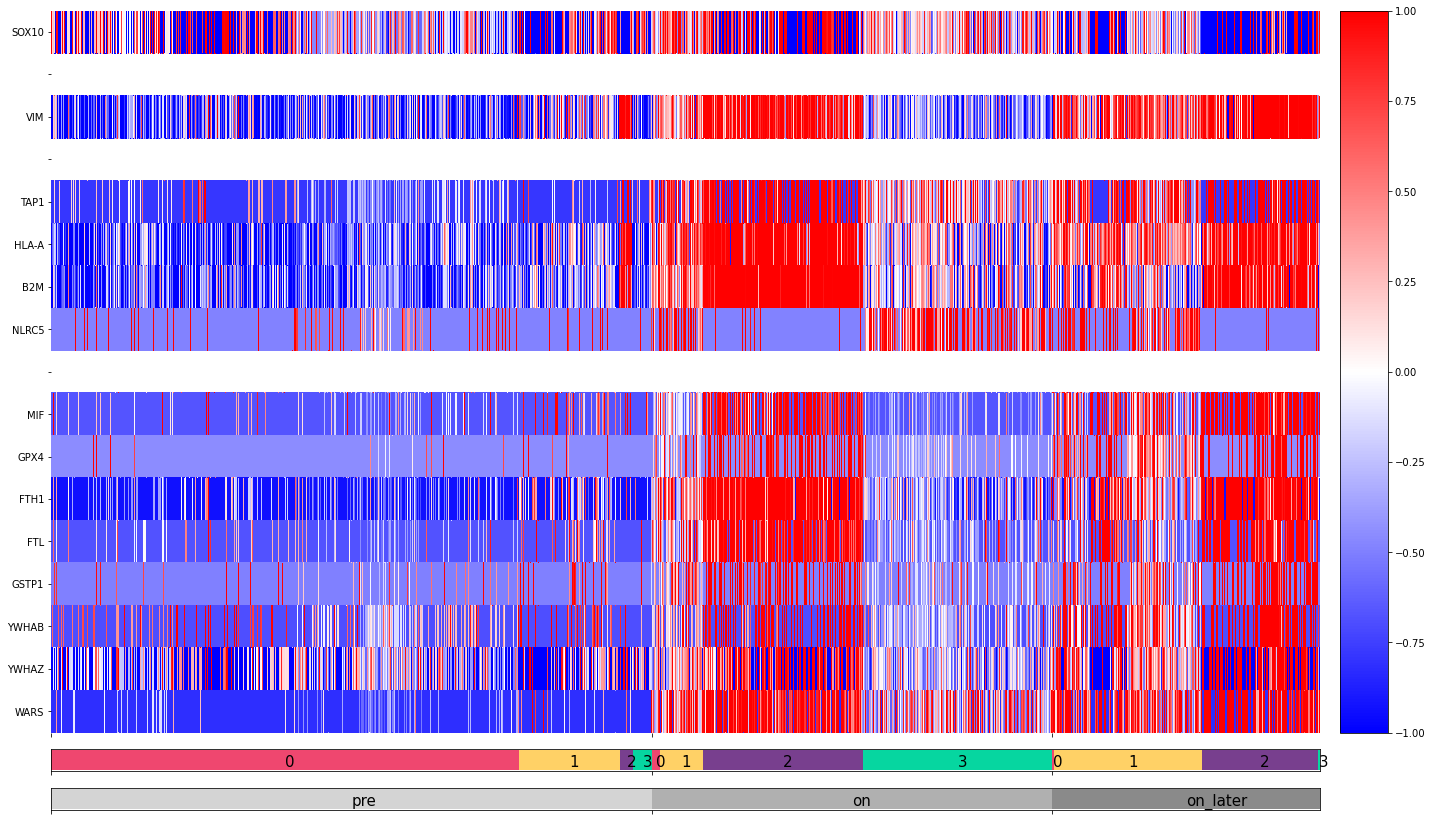

In [12]:
genes=full_heatmap(selected_genes, "selected",r310,vmax=1,thresh=300,mean_thresh=0)